## KKAN for MNIST

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
from KKANLayer import KKANLayer

In [ ]:
# Construct a KKAN for MNIST
g = 8

class MNIST_KKAN(nn.Module):
    def __init__(self):
        super(MNIST_KKAN, self).__init__()
        self.kkan1 = KKANLayer(28*28, 128, g) # g  = 10
        self.kkan2 = KKANLayer(128, 32, g)
        self.kkan3 = KKANLayer(32, 10, g)

    def forward(self, x):
        x = x.view(-1, 28*28)  # Flatten the images
        x = self.kkan1(x)
        x = self.kkan2(x)
        x = self.kkan3(x)
        return x

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MNIST_KKAN().to(device)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params}")

Total trainable parameters: 1676288


In [ ]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0

    for idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        if isinstance(optimizer, optim.LBFGS):
            def closure():
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                loss.backward()
                return loss
            loss = optimizer.step(closure)
        else:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            loss = loss.item()

        total_loss += loss

    return total_loss / len(train_loader)

def validate(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            total_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    return total_loss / len(test_loader), correct / len(test_loader.dataset)

In [ ]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = []
test_losses = []

epochs = 40
for epoch in range(epochs):
    train_loss = train(model, train_loader, criterion, optimizer, device)
    test_loss, test_accuracy = validate(model, test_loader, criterion, device)

    train_losses.append(train_loss)
    test_losses.append(test_loss)

    print(f'Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, '
          f'Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}')



Epoch 1, Train Loss: 0.8549, Test Loss: 0.6051, Test Acc: 0.81
Epoch 2, Train Loss: 0.5196, Test Loss: 0.4422, Test Acc: 0.87
Epoch 3, Train Loss: 0.4465, Test Loss: 0.4424, Test Acc: 0.87
Epoch 4, Train Loss: 0.4090, Test Loss: 0.3697, Test Acc: 0.89
Epoch 5, Train Loss: 0.3823, Test Loss: 0.3922, Test Acc: 0.89
Epoch 6, Train Loss: 0.3670, Test Loss: 0.3750, Test Acc: 0.89
Epoch 7, Train Loss: 0.3520, Test Loss: 0.3538, Test Acc: 0.91
Epoch 8, Train Loss: 0.3401, Test Loss: 0.3729, Test Acc: 0.90
Epoch 9, Train Loss: 0.3278, Test Loss: 0.3140, Test Acc: 0.91
Epoch 10, Train Loss: 0.3220, Test Loss: 0.3175, Test Acc: 0.91
Epoch 11, Train Loss: 0.3097, Test Loss: 0.3072, Test Acc: 0.91
Epoch 12, Train Loss: 0.3069, Test Loss: 0.3072, Test Acc: 0.92
Epoch 13, Train Loss: 0.3026, Test Loss: 0.3439, Test Acc: 0.90
Epoch 14, Train Loss: 0.3003, Test Loss: 0.2988, Test Acc: 0.92
Epoch 15, Train Loss: 0.2908, Test Loss: 0.2949, Test Acc: 0.92
Epoch 16, Train Loss: 0.2813, Test Loss: 0.2842, 

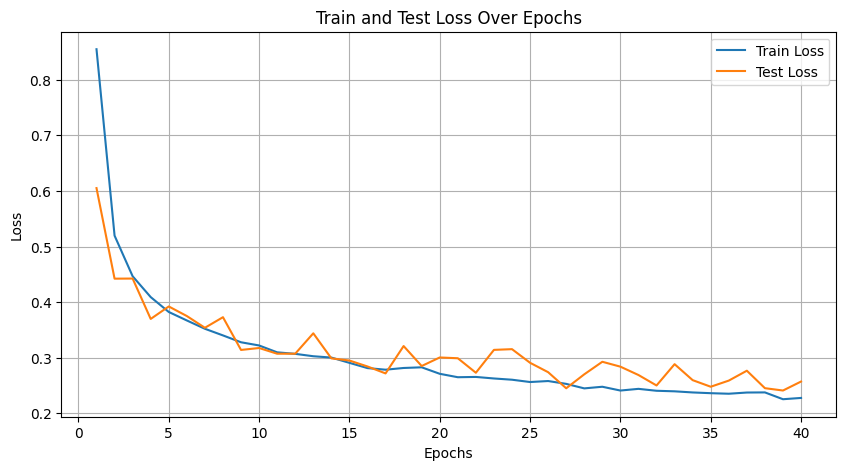

In [ ]:
# Plot

plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), test_losses, label='Test Loss')
plt.title('Train and Test Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Test examples

Target: 2, Prediction: 2, Correct: 1


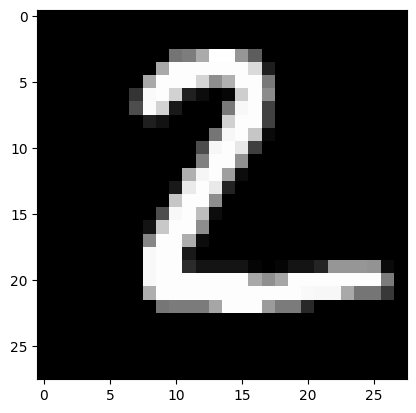

In [ ]:
# Test number two
data = test_loader.dataset.data[1].to(device)
target = test_loader.dataset.targets[1].to(device)

model.eval()
output = model(data)
pred = output.argmax(dim=1, keepdim=True)
correct = pred.eq(target.view_as(pred)).sum().item()

print(f'Target: {target}, Prediction: {pred[0][0]}, Correct: {correct}')

image = data.squeeze(0).cpu().numpy()

plt.imshow(image, cmap='gray')
plt.show()


Target: 0, Prediction: 0, Correct: 1


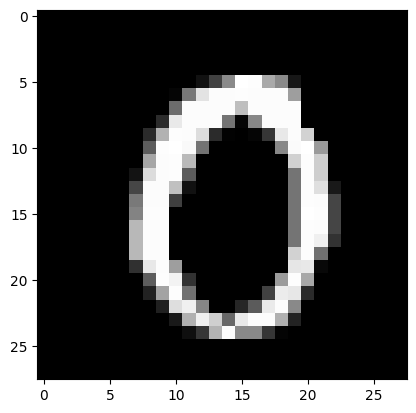

In [ ]:
# Test number zero
data = test_loader.dataset.data[13].to(device)
target = test_loader.dataset.targets[13].to(device)

model.eval()
output = model(data)
pred = output.argmax(dim=1, keepdim=True)
correct = pred.eq(target.view_as(pred)).sum().item()

print(f'Target: {target}, Prediction: {pred[0][0]}, Correct: {correct}')

image = data.squeeze(0).cpu().numpy()

plt.imshow(image, cmap='gray')
plt.show()
